In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17279018139324793731
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15240134656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10874306262615197437
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # num_classes è il numero di classi nel tuo dataset

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# # Weights & Biases  (optional)
# %pip install -q wandb
# import wandb
# wandb.login()

!pip install wandb
!wandb login
import wandb

!wandb enabled

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=1ab13e63114dba968fc6676d9c0dac11d14b25819957720fedda134cffb0f846
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
W&B ena

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

run = wandb.init(
    # Set the project where this run will be logged
    project="my-vgg16_new")

batch_size = 256
num_epochs = 40


# Definisci l'ottimizzatore
optimizer = Adam(lr=0.001)

# Compila il modello
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Specifica i percorsi delle cartelle di addestramento e validazione
train_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/train_folder'
val_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/val_folder'

wandb: Currently logged in as: gcicceri. Use `wandb login --relogin` to force relogin


In [ ]:
# Utilizza l'ImageDataGenerator per la generazione di dati
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Definisci i generatori di dati per l'addestramento e la validazione
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 18537 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.


In [ ]:
# Esegui il fine-tuning del modello
#history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=num_epochs, validation_data=val_generator, validation_steps=val_generator.n // batch_size)

In [ ]:
import time
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint_filepath = '/content/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Start measuring time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[model_checkpoint_callback]  # Add the ModelCheckpoint to the callbacks list
)

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost for model.fit: {computational_cost} seconds")


Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7284  
Epoch 1: val_loss improved from inf to 0.55203, saving model to /content/best_model.h5
72/72 [==============================] - 9045s 126s/step - loss: 0.7032 - accuracy: 0.7284 - val_loss: 0.5520 - val_accuracy: 0.7812
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.7880
Epoch 2: val_loss improved from 0.55203 to 0.48979, saving model to /content/best_model.h5
72/72 [==============================] - 78s 1s/step - loss: 0.5441 - accuracy: 0.7880 - val_loss: 0.4898 - val_accuracy: 0.8003
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7978
Epoch 3: val_loss improved from 0.48979 to 0.47652, saving model to /content/best_model.h5
72/72 [==============================] - 78s 1s/step - loss: 0.5172 - accuracy: 0.7978 - val_loss: 0.4765 - val_accuracy: 0.8047
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8077
Epoch 4: val_loss improved from 0.47652 to 0.45466, saving model to /content/best_model.h5
72/72 [==============================] - 77s 1s/step - loss: 0.4894 - accuracy: 0.8077 - val_loss: 0.4547 - val_accuracy: 0.8232
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0

In [ ]:
#track the curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

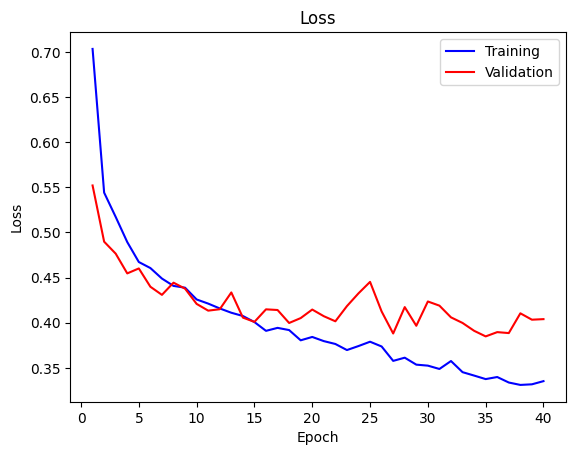

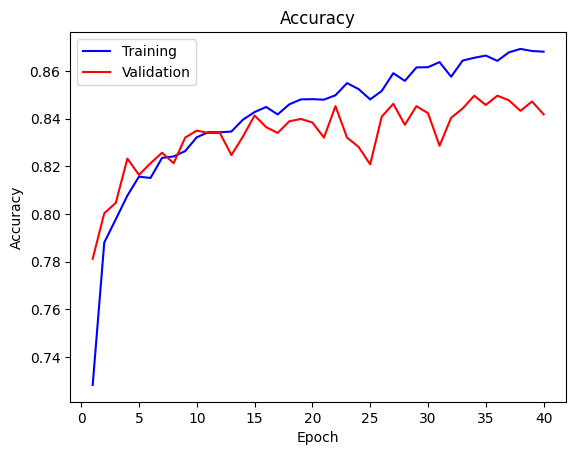

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have defined train_loss, val_loss, train_acc, and val_acc

epochs = range(1, len(train_loss) + 1)

# Plot and save the loss figure with 600 DPI
plt.plot(epochs, train_loss, 'b-', label='Training')
plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('loss_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot and save the accuracy figure with 600 DPI
plt.plot(epochs, train_acc, 'b-', label='Training')
plt.plot(epochs, val_acc, 'r-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('accuracy_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/test_folder'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2468 images belonging to 4 classes.


In [ ]:
import time
import numpy as np

# Start measuring time
start_time = time.time()

# Assuming you have defined test_generator and model as mentioned in your code
# This is just for measuring the time spent on loading data and making predictions

# Load true labels
y_true = test_generator.classes  # Etichette reali

# Make predictions
y_pred = model.predict(test_generator)  # Previsioni del modello

# Calculate predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Classi predette

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost: {computational_cost} seconds")

10/10 [==============================] - 531s 59s/step
Computational cost: 546.9195234775543 seconds


In [ ]:
#DA PROVARE

import time
import numpy as np
from keras.models import load_model

# Load the best model
model_path = '/content/best_model.h5'
model = load_model(model_path)

# Start measuring time
start_time = time.time()

# Assuming you have defined test_generator
# This is just for measuring the time spent on loading data and making predictions

# Load true labels
y_true = test_generator.classes  # Etichette reali

# Make predictions
y_pred = model.predict(test_generator)  # Previsioni del modello

# Calculate predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Classi predette

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost: {computational_cost} seconds")


10/10 [==============================] - 9s 923ms/step
Computational cost: 10.633018255233765 seconds


In [ ]:
y_pred

array([[9.9611193e-01, 3.5178373e-03, 5.5590554e-08, 3.7018341e-04],
       [9.4420159e-01, 2.1043324e-03, 1.1860520e-05, 5.3682156e-02],
       [9.5350206e-01, 1.1666251e-02, 5.1586620e-05, 3.4780085e-02],
       ...,
       [9.5547980e-01, 1.9551191e-02, 3.5781690e-05, 2.4933267e-02],
       [9.0941197e-01, 4.5677569e-02, 3.8958841e-04, 4.4520814e-02],
       [5.4487282e-01, 5.1634968e-03, 6.0298975e-05, 4.4990334e-01]],
      dtype=float32)

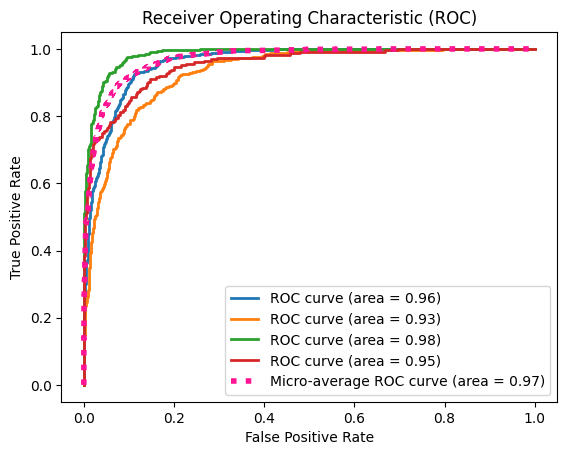

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have defined y_true and y_pred_classes as described in your code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Binarize the true labels (one-hot encoding)
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"],
         color='deeppink', linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('roc_curves.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


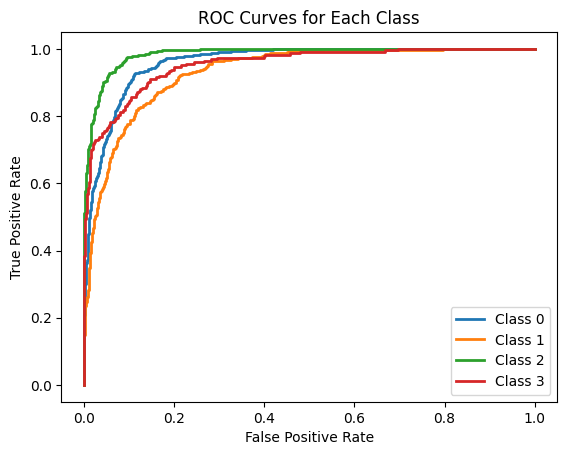

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, label=f'Class {i}')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.savefig('roc_curves_for_class.png', format='png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

# Save FPR and TPR values to separate CSV files for each class
for i in range(n_classes):
    class_name = f'Class_{i}'
    fpr = fpr_dict[i]
    tpr = tpr_dict[i]

    # Save FPR and TPR values for the class to a CSV file
    with open(f'{class_name}_roc_curve.csv', 'w') as file:
        file.write('False Positive Rate, True Positive Rate\n')
        for j in range(len(fpr)):
            file.write(f'{fpr[j]}, {tpr[j]}\n')


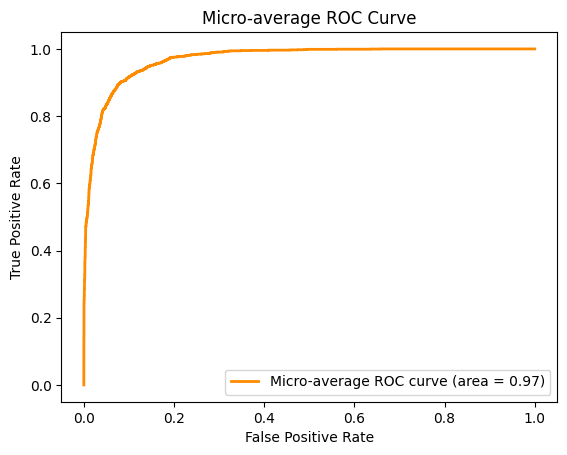

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='darkorange',
         lw=lw, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('micro_avg_roc_curves.png', format='png', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()

import pandas as pd

# Create a dataframe with fpr_micro and tpr_micro
df = pd.DataFrame({'fpr_micro': fpr_micro, 'tpr_micro': tpr_micro})

# Save the dataframe to a CSV file
df.to_csv('fpr_tpr_micro_values.csv', index=False)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8419773095623987
Precision: 0.8413890062943101
Recall: 0.8419773095623987
F1-score: 0.8398000408116263


In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Matrice di confusione:")
print(confusion_mtx)


Matrice di confusione:
[[1215   57    1   21]
 [ 100  402   36   10]
 [   1   85  313    2]
 [  66    9    2  148]]


In [ ]:
# Assuming you have defined confusion_mtx as described in your code

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Save the confusion matrix values to a text file (e.g., CSV)
with open('confusion_matrix.csv', 'w') as file:
    file.write("Confusion Matrix:\n")
    for row in confusion_mtx:
        file.write(','.join(map(str, row)) + '\n')

Confusion Matrix:
[[1215   57    1   21]
 [ 100  402   36   10]
 [   1   85  313    2]
 [  66    9    2  148]]


In [ ]:
#print PPT

import numpy as np
from sklearn.metrics import roc_curve

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Print TPR and FPR for each class
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"TPR (True Positive Rate): {tpr_dict[i]}")
    print(f"FPR (False Positive Rate): {fpr_dict[i]}")
    print()


Class 0:
TPR (True Positive Rate): [0.00000000e+00 7.72797527e-04 4.63678516e-03 6.18238022e-03
 1.33693972e-01 1.33693972e-01 2.08655332e-01 2.08655332e-01
 2.92117465e-01 2.92117465e-01 2.99072643e-01 2.99072643e-01
 3.09891808e-01 3.09891808e-01 3.63987635e-01 3.63987635e-01
 3.66306028e-01 3.66306028e-01 3.68624420e-01 3.68624420e-01
 3.71715611e-01 3.71715611e-01 3.88717156e-01 3.88717156e-01
 4.28902628e-01 4.28902628e-01 4.49768161e-01 4.49768161e-01
 4.50540958e-01 4.50540958e-01 4.95363215e-01 4.95363215e-01
 5.05409583e-01 5.05409583e-01 5.20092736e-01 5.20092736e-01
 5.27820711e-01 5.27820711e-01 5.44822257e-01 5.44822257e-01
 5.74961360e-01 5.74961360e-01 5.77279753e-01 5.77279753e-01
 5.81916538e-01 5.81916538e-01 5.85007728e-01 5.85007728e-01
 5.91962906e-01 5.91962906e-01 5.93508501e-01 5.93508501e-01
 6.02009274e-01 6.02009274e-01 6.04327666e-01 6.04327666e-01
 6.06646059e-01 6.06646059e-01 6.08191654e-01 6.08191654e-01
 6.12055641e-01 6.12055641e-01 6.15919629e-01 6.15

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have defined y_true and y_pred_classes as described in your previous code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate classification report
classification_rep = classification_report(y_true, y_pred_classes)

# Calculate overall accuracy
accuracy = np.mean(y_true == y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("\nClassification Report:")
print(classification_rep)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy:.2%}")


Confusion Matrix:
[[1215   57    1   21]
 [ 100  402   36   10]
 [   1   85  313    2]
 [  66    9    2  148]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1294
           1       0.73      0.73      0.73       548
           2       0.89      0.78      0.83       401
           3       0.82      0.66      0.73       225

    accuracy                           0.84      2468
   macro avg       0.83      0.78      0.80      2468
weighted avg       0.84      0.84      0.84      2468


Overall Accuracy: 84.20%


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have defined y_true and y_pred_classes as described in your previous code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate sensitivity (TPR) and specificity for each class
sensitivity = []
specificity = []

for i in range(len(confusion_mtx)):
    true_positives = confusion_mtx[i, i]
    false_negatives = np.sum(confusion_mtx[i, :]) - true_positives
    true_negatives = np.sum(confusion_mtx) - np.sum(confusion_mtx[i, :]) - np.sum(confusion_mtx[:, i]) + true_positives
    false_positives = np.sum(confusion_mtx[:, i]) - true_positives

    sensitivity_i = true_positives / (true_positives + false_negatives)
    specificity_i = true_negatives / (true_negatives + false_positives)

    sensitivity.append(sensitivity_i)
    specificity.append(specificity_i)

# Print sensitivity and specificity for each class
for i in range(len(sensitivity)):
    print(f"Class {i}:")
    print(f"Sensitivity (True Positive Rate): {sensitivity[i]:.2f}")
    print(f"Specificity (True Negative Rate): {specificity[i]:.2f}")
    print()


Class 0:
Sensitivity (True Positive Rate): 0.94
Specificity (True Negative Rate): 0.86

Class 1:
Sensitivity (True Positive Rate): 0.73
Specificity (True Negative Rate): 0.92

Class 2:
Sensitivity (True Positive Rate): 0.78
Specificity (True Negative Rate): 0.98

Class 3:
Sensitivity (True Positive Rate): 0.66
Specificity (True Negative Rate): 0.99



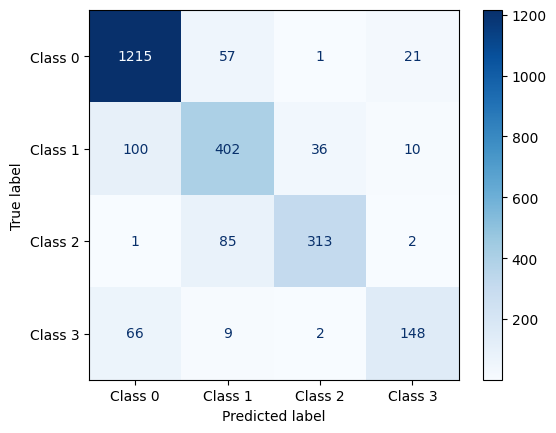

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Display labels for the classes
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Save the figure as a PNG file
plt.savefig('cm_conf_4_classes.png', dpi=100)

# Show the plot
plt.show()
